![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

## Introduction to Text Mining and Natural Language Processing


## Session 4: From Corpus to DTM: preprocessing + vectorization

We will now repeat the content from the TA session and pre-process a small corpus. Please make sure the code below runs before the lecture or soon into the lecture.

The code below contains a pipeline that offers three options:

- modulation=0: convert to lower case

- modulation=1: lowercasing + stemming

- modulation=2: lemmatizing (keeps some capital letters around)

The pipeline always does: tokenization, remove punctuation, remove stopwords

We will then make counts -> document-term matrix (vectorization). Here we will first see a "manual" version where we can look at what the code does and then a second version that uses the CountVectorizer package from the Sklearn.

The key take-away of this session will be an understanding of the count vectorizer. This code generates some of the pictures we will see in the lecture.


### Context of the Data

The text data in this corpus is scraped from the World Economic Forum webpage (with some effort). I have the speaker of and their full text that was cleaned by ChatGPT. There are some mistakes - this is not clean data for sure. But it serves some illustrative purpose.

### Exercise

Try to process the data. I will give you the beginning and you will have to process all.



In [106]:
# Install necessary packages

import os
import re
import csv
import sys
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer
from nltk.corpus import stopwords
import spacy
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm

# Function to download NLTK resources
def download_nltk_resources():
    required_resources = ['wordnet', 'stopwords', 'punkt_tab']
    for resource in required_resources:
        try:
            nltk.data.find(f'tokenizers/{resource}' if resource == 'punkt' else f'corpora/{resource}')
        except LookupError:
            nltk.download(resource)

download_nltk_resources()

# Function to install and load spaCy model
def install_spacy_model(model_name):
    try:
        return spacy.load(model_name)
    except OSError:
        print(f"Downloading spaCy model: {model_name}")
        subprocess.check_call([sys.executable, "-m", "spacy", "download", model_name])
        return spacy.load(model_name)

sp = install_spacy_model('en_core_web_sm')

# Enable tqdm for pandas
tqdm.pandas()

# Initialize stemmers and lemmatizer
porter = SnowballStemmer("english")
lmtzr = WordNetLemmatizer()
STOP_WORDS = set(stopwords.words('english'))



[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hannesfelixmuller/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/hannesfelixmuller/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [107]:
# Set paths
path='/Users/hannesfelixmuller/Dropbox/teaching/Text Mining DSDM 2026/Session4_vectors_tfidf/'
spitout='/Users/hannesfelixmuller/Dropbox/teaching/Text Mining DSDM 2026/Session4_vectors_tfidf/'


# Ensure the directory exists
if not os.path.exists(path):
    os.makedirs(path)

# Define your file path and filename.
filename = "WEF_speeches.csv"

# Load the data with error handling
try:
    corpus_data = pd.read_csv(os.path.join(path, filename), sep=',', encoding='utf-8')
    corpus_data.info()
except FileNotFoundError:
    print(f"File {filename} not found in directory {path}. Please ensure the file exists.")
    sys.exit(1)


print("The texts are about two different leaders speaking:")
corpus_data.speaker.value_counts()


<class 'pandas.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   year                  24 non-null     int64
 1   date                  24 non-null     str  
 2   speaker               24 non-null     str  
 3   role                  24 non-null     str  
 4   country_or_org        24 non-null     str  
 5   session_title         24 non-null     str  
 6   type                  24 non-null     str  
 7   transcript_url        18 non-null     str  
 8   video_url             15 non-null     str  
 9   notes                 24 non-null     str  
 10  full_text             16 non-null     str  
 11  source                16 non-null     str  
 12  full_text_raw_backup  16 non-null     str  
 13  full_text_len         24 non-null     int64
 14  title                 16 non-null     str  
dtypes: int64(2), str(13)
memory usage: 2.9 KB
The texts are about two diff

speaker
António Guterres        3
Ursula von der Leyen    3
Emmanuel Macron         2
Olaf Scholz             2
Pedro Sánchez           2
Javier Milei            2
Volodymyr Zelenskyy     2
Mark Carney             1
He Lifeng               1
Donald J. Trump         1
Abdel Fattah El-Sisi    1
Guy Parmelin            1
Ding Xuexiang           1
Li Qiang                1
Yoon Suk Yeol           1
Name: count, dtype: int64

In [108]:
#only keep full nice speeches
corpus_data.full_text_len.value_counts()

corpus_data=corpus_data[corpus_data.full_text_len>3000].reset_index()

corpus_data.speaker.value_counts()


speaker
António Guterres        2
Ursula von der Leyen    2
Javier Milei            2
Mark Carney             1
Emmanuel Macron         1
He Lifeng               1
Ding Xuexiang           1
Volodymyr Zelenskyy     1
Li Qiang                1
Olaf Scholz             1
Pedro Sánchez           1
Name: count, dtype: int64

In [54]:
"""
This module provides helper functions for text preprocessing. 
Each function applies punctuation removal and stopword removal, and then one of three options:
    0: Lowercasing only.
    1: Lowercasing plus stemming.
    2: Lemmatizing (using spaCy; original casing is preserved).

The functions return a string of tokens separated by spaces.
"""

def preprocess_lower(text):
    """
    Preprocess text by:
       - Converting to lowercase.
       - Removing punctuation.
       - Tokenizing.
       - Removing stopwords.
    
    Returns:
        str: A string of filtered tokens separated by spaces.
    """
    text_lower = text.lower()
    text_no_punct = re.sub(r'[^\w\s]', '', text_lower)
    tokens = word_tokenize(text_no_punct)
    filtered_tokens = [token for token in tokens if token not in STOP_WORDS]
    return " ".join(filtered_tokens)

def preprocess_stem(text):
    """
    Preprocess text by performing all steps in preprocess_lower() and then applying stemming.
    
    Returns:
        str: A string of stemmed tokens separated by spaces.
    """
    tokens = preprocess_lower(text).split()
    ps = PorterStemmer()
    stemmed_tokens = [ps.stem(token) for token in tokens]
    return " ".join(stemmed_tokens)

def preprocess_lemma(text):
    """
    Preprocess text by:
       - Removing punctuation and stopwords using spaCy's token attributes.
       - Lemmatizing the text.
       - (Note: This function does NOT lowercase the text.)
    
    Returns:
        str: A string of lemmatized tokens separated by spaces.
    """
    doc = sp(text)
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.lemma_.strip() != '']
    return " ".join(lemmatized_tokens)


def tokenize(text, mode=0):
    """
    General tokenize function. Always applies punctuation and stopword removal and then:
    
      mode = 0: Applies lowercasing.
      mode = 1: Applies lowercasing and stemming.
      mode = 2: Applies lemmatization (without lowercasing the original text).
    
    Args:
        text (str): The input text to be processed.
        mode (int): Processing mode (0 for lowercasing; 1 for stemming; 2 for lemmatizing).

    Returns:
        str: A string of processed tokens separated by spaces.

    Raises:
        ValueError: If an invalid mode is provided.
    """
    if mode == 0:
        return preprocess_lower(text)
    elif mode == 1:
        return preprocess_stem(text)
    elif mode == 2:
        return preprocess_lemma(text)
    else:
        raise ValueError("Invalid mode. Please use 0 for lowercasing, 1 for stemming, or 2 for lemmatizing.")


In [73]:
corpus_data.full_text.astype(str)

0     Thank you very much, Larry. I'm going to start...
1     Thank you very much for your words. Your majes...
2     Ladies and gentlemen, friends, over the past f...
3     Ladies and gentlemen,\nIt’s good to be back in...
4     Ladies and Gentlemen,\nThe first quarter of th...
5     Ladies and Gentlemen,\nFriends,\nChina is a ke...
6     Good morning everyone. And how much has change...
7     Ladies and gentlemen,\nI want to talk about th...
8     Ladies and gentlemen, our world is in an era o...
9     Ladies and Gentlemen,\nFriends,\nUnder the cur...
10    Good afternoon. Thank you very much.\nToday I'...
11    Ladies and gentlemen,\nA climate-neutral futur...
12    Thank you for your welcome. It is good to be b...
13    Davos 2023: Special Address by Pedro Sánchez, ...
Name: full_text, dtype: str

In [100]:
#some fake titles
corpus_data.title.astype(str)

0     Territorial Integrity Various States: Developm...
1                               Point View: Russian War
2                           Years China: Reform Opening
3     Middle East: Rights Multiplication Conflicts L...
4     Expanding Faster Trade Common: Unambiguous For...
5                         Chinese Economy: High Quality
6         Result Having: Ghost Western Christmases Come
7                        United States: Abandon Someday
8                Rebuild Trust: Key Role Thank Chairman
9               Chinese Economy: Zoom Look Afar Chinese
10                Model Freedom: Willing Help Motivated
11                         Club Launched: High Emission
12    Coat Scale Challenge Sorry: Person Theme Perfe...
13    Democratic Values Multilateralism: New Ones Su...
Name: title, dtype: str

# Do not scroll - think

In [110]:
corpus_data.full_text.astype(str)[0]

"Thank you very much, Larry. I'm going to start in French, and then I'll switch back to English.\n[The following is translated from French]\nThank you, Larry. It is both a pleasure, and a duty, to be with you tonight in this pivotal moment that Canada and the world going through.\nToday I will talk about a rupture in the world order, the end of a pleasant fiction and the beginning of a harsh reality, where geopolitics, where the large, main power, geopolitics, is submitted to no limits, no constraints.\nOn the other hand, I would like to tell you that the other countries, especially intermediate powers like Canada, are not powerless. They have the capacity to build a new order that encompasses our values, such as respect for human rights, sustainable development, solidarity, sovereignty and territorial integrity of the various states.\nThe power of the less power starts with honesty.\n[Carney returns to speaking in English]\nIt seems that every day we're reminded that we live in an era

In [115]:

# Set mode (0 = lowercasing, 1 = stemming, 2 = lemmatizing)
mod = 2

corpus_data["text_preproc"] = corpus_data["full_text"].astype(str).apply(lambda x: tokenize(x, mode=2))

corpus_data["title_preproc"] = corpus_data["title"].astype(str).apply(lambda x: tokenize(x, mode=2))




In [116]:
corpus_data["text_preproc"][0]

"thank much Larry go start French switch back English following translate French thank Larry pleasure duty tonight pivotal moment Canada world go today talk rupture world order end pleasant fiction beginning harsh reality geopolitic large main power geopolitic submit limit constraint hand would like tell country especially intermediate power like Canada powerless capacity build new order encompass value respect human right sustainable development solidarity sovereignty territorial integrity various state power less power start honesty carney return speak English seem every day remind live era great power rivalry rule base order fade strong weak must suffer must aphorism Thucydides present inevitable natural logic international relation reassert face logic strong tendency country go along get along accommodate avoid trouble hope compliance buy safety well option 1978 Czech dissident Václav Havel later president write essay call Power Powerless ask simple question communist system sustai

In [118]:
#raw text
print(corpus_data.title_preproc[0])

Territorial Integrity Various States Development Solidarity Sovereignty


# The sklearn countvectorizer

It takes about 1/4th of the time to vectorize with the CV package.

In [119]:
%%time
cv = CountVectorizer(ngram_range = (1,1), lowercase=False)
cv.fit(corpus_data.text_preproc)



vectorized_text=cv.transform(corpus_data.text_preproc)
vectorized_text=vectorized_text.todense()
print("document term matrix has size:", vectorized_text.shape)

#slight difference in dimensions to vectorization by hand 
#probably because of pre-processing in the CountVectorizer

document term matrix has size: (14, 3238)
CPU times: user 13.5 ms, sys: 1.79 ms, total: 15.3 ms
Wall time: 14.8 ms


In [120]:
len(cv.get_feature_names_out())

3238

In [121]:
print(cv.get_feature_names_out())

['002' '066' '10' ... 'yuan' 'zero' 'zoom']


## Countvectorizer setting hyperparameters

Now imagine  if we want to preprocess the titles as well and perhaps later compare, how should we do it?

It is crucial that you understand the answer: we want to fit on the text overall and then "predict" on titles.

In [122]:
#note I am not calling cv.fit - understand why!
vectorized_titles=cv.transform(corpus_data.title_preproc)
vectorized_titles=vectorized_titles.todense()
print("document term matrix of titles has size:", vectorized_titles.shape)

document term matrix of titles has size: (14, 3238)


## Experiment with the CountVectorizer

Use the following options:

- ngram_range=(1, 1), (1,2), (2,2), (3,3)

- max_df=1.0, 0.5, 0.2

- min_df=1, 5, 0.1

How does it affect the vocabulary you get out?

In [126]:

cv = CountVectorizer(ngram_range = (2,3),  min_df=3, lowercase=False)
cv.fit(corpus_data.text_preproc)
vectorized_text=cv.transform(corpus_data.text_preproc)
vectorized_text=vectorized_text.todense()
print("document term matrix has size", vectorized_text.shape)
print(cv.get_feature_names_out())

document term matrix has size (14, 124)
['300 million' 'China opportunity' 'China world' 'Europe must'
 'European Commission' 'Global South' 'Middle East' 'Paris Agreement'
 'Prime Minister' 'United States' 'around world' 'artificial intelligence'
 'back Davos' 'billion people' 'build new' 'business environment'
 'business leader' 'capital market' 'chinese economy'
 'chinese economy make' 'chinese market' 'chinese modernization'
 'climate change' 'come back' 'come end' 'conclude wish' 'develop country'
 'economic development' 'economic growth' 'economic social'
 'economy China' 'economy make' 'economy make steady' 'economy world'
 'energy transition' 'export control' 'fast pace' 'five year'
 'foreign investment' 'fossil fuel' 'free trade' 'global economic'
 'global economy' 'global order' 'global problem' 'global trade'
 'good service' 'great thank' 'green energy' 'green low'
 'green low carbon' 'growth rate' 'high quality'
 'high quality development' 'human right' 'international law'


In [127]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the simple CountVectorizer
cv_simple = CountVectorizer(ngram_range=(1,3), lowercase=False)

# Fit the vectorizer to the preprocessed text data
X_simple = cv_simple.fit_transform(corpus_data.text_preproc)

# Get the vocabulary (terms)
terms = cv_simple.get_feature_names_out()

# Calculate term frequencies (total counts across all documents)
term_frequencies = X_simple.toarray().sum(axis=0)

# Create a DataFrame for easier handling
import pandas as pd

df_terms = pd.DataFrame({
    'term': terms,
    'frequency': term_frequencies
})

# Sort the DataFrame by frequency in descending order
df_terms = df_terms.sort_values(by='frequency', ascending=False).reset_index(drop=True)

#assign and id
df_terms['id'] = df_terms.index + 1

# Display the top 10 terms as a sanity check
print(df_terms.head(10))



      term  frequency  id
0    world        175   1
1    China        123   2
2   Europe        122   3
3     year        107   4
4  country        103   5
5   global         93   6
6   market         82   7
7      one         79   8
8      new         77   9
9     must         74  10


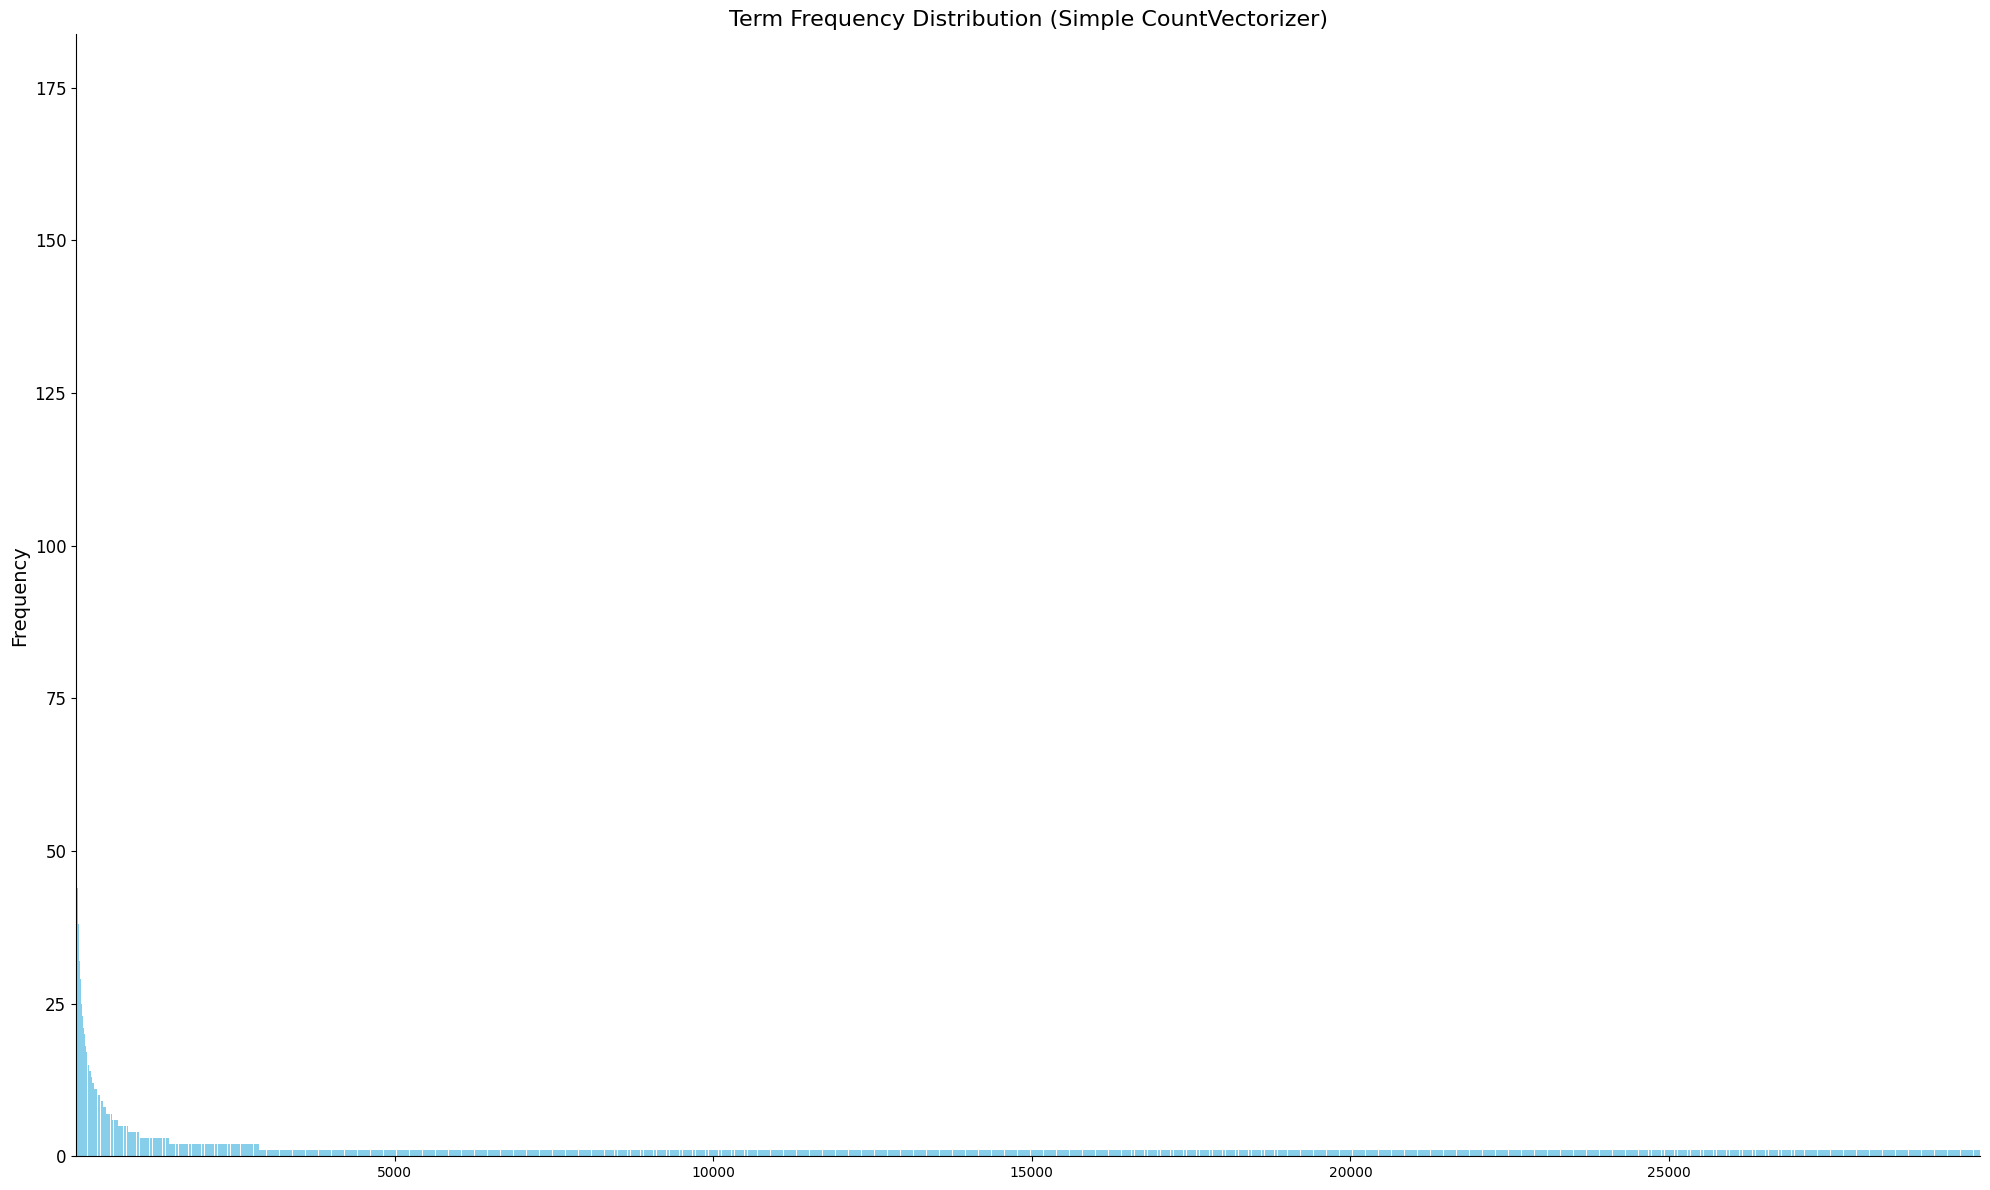

In [128]:
# Define the total number of terms
V = df_terms.shape[0]

# Create the x-axis IDs
x_ids = df_terms['id']

# Get the corresponding frequencies
frequencies = df_terms['frequency']

plt.figure(figsize=(20, 12))

# Create the bar plot with increased width and centered alignment
plt.bar(x_ids, frequencies, width=0.9, color='skyblue', align='center')

# Remove x-axis labels and tick marks
plt.xlabel('')
plt.ylabel('Frequency', fontsize=14)
plt.title('Term Frequency Distribution (Simple CountVectorizer)', fontsize=16)

# Customize the spines to retain only the bottom and left spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

# Set x-axis limits to ensure the first bar starts at x=1
plt.xlim(0.5, V + 0.5)

# Ensure y-axis ticks are visible and appropriately sized
plt.yticks(fontsize=12)

# Apply log scale to the y-axis
#plt.yscale('log')

# Optimize layout for better spacing
plt.tight_layout()

output_path = os.path.join(spitout, 'figures/term_frequency_distribution_simple.pdf')
plt.savefig(output_path, format='pdf')

# Display the plot
plt.show()


In [130]:
# Initialize the simple CountVectorizer
cv_simple = CountVectorizer(ngram_range=(1,3), min_df=3, lowercase=False)

# Fit the vectorizer to the preprocessed text data
X_simple = cv_simple.fit_transform(corpus_data.text_preproc)

# Get the vocabulary (terms)
terms = cv_simple.get_feature_names_out()

# Calculate term frequencies (total counts across all documents)
term_frequencies = X_simple.sum(axis=0).A1  # Convert to 1D array

# Create a DataFrame for easier handling
df_terms = pd.DataFrame({
    'term': terms,
    'frequency': term_frequencies
})

# Sort the DataFrame by frequency in descending order
df_terms = df_terms.sort_values(by='frequency', ascending=False).reset_index(drop=True)

# Assign an ID from 1 (most frequent) to V (least frequent)
df_terms['id'] = df_terms.index + 1

# Display the top 10 terms as a sanity check
print(df_terms.head(10))

      term  frequency  id
0    world        175   1
1    China        123   2
2   Europe        122   3
3     year        107   4
4  country        103   5
5   global         93   6
6   market         82   7
7      one         79   8
8      new         77   9
9     must         74  10


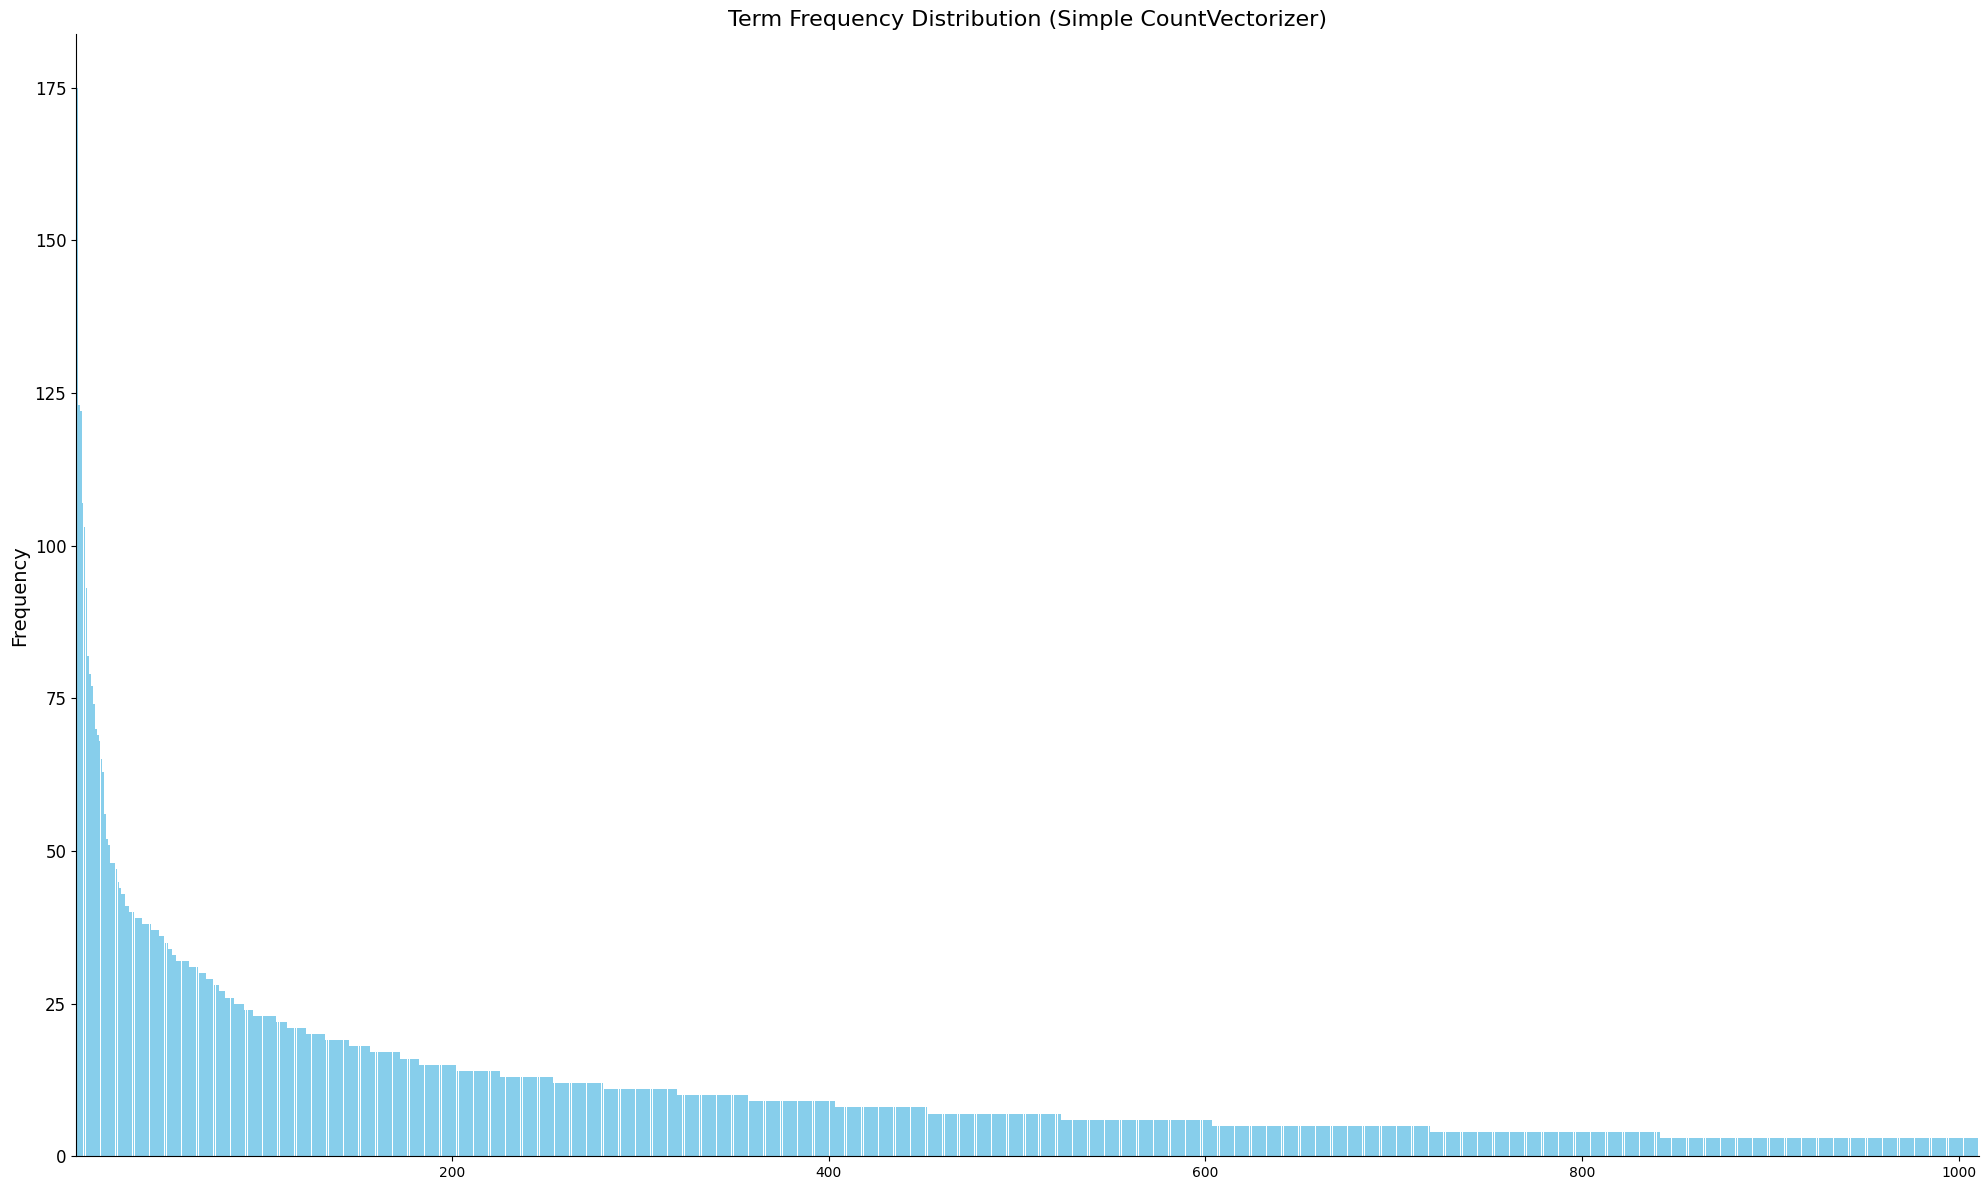

In [131]:
# Define the total number of terms
V = df_terms.shape[0]

# Create the x-axis IDs
x_ids = df_terms['id']

# Get the corresponding frequencies
frequencies = df_terms['frequency']

plt.figure(figsize=(20, 12))

# Create the bar plot with increased width and centered alignment
plt.bar(x_ids, frequencies, width=0.9, color='skyblue', align='center')

# Remove x-axis labels and tick marks
plt.xlabel('')
plt.ylabel('Frequency', fontsize=14)
plt.title('Term Frequency Distribution (Simple CountVectorizer)', fontsize=16)

# Customize the spines to retain only the bottom and left spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

# Set x-axis limits to ensure the first bar starts at x=1
plt.xlim(0.5, V + 0.5)

# Ensure y-axis ticks are visible and appropriately sized
plt.yticks(fontsize=12)

# Apply log scale to the y-axis
#plt.yscale('log')

# Optimize layout for better spacing
plt.tight_layout()

output_path = os.path.join(spitout, 'figures/term_frequency_distribution_strict.pdf')
plt.savefig(output_path, format='pdf')

# Display the plot
plt.show()

# Now towards the project

I experimented with the tfidf count vectorizer. What I want to do is to make visible how Mark Carney spoke differently. So I actually need to mantain his indivuality. At the same time I want to make sure it is not just a plain english vocabulary difference that I capture. What I converged on is to make min_df=1 but then to choose only bi-grams and tri-grams.

In [157]:
# Cell 1 — TF-IDF vectorization (keeps acronyms; min_df=3, max_df=0.5)

from sklearn.feature_extraction.text import TfidfVectorizer

# Use your preprocessed text column; fall back to full_text if needed
text_col = "text_preproc" if "text_preproc" in corpus_data.columns else "full_text"

tfidf = TfidfVectorizer(
    ngram_range=(2,3),
    min_df=1,
    max_df=0.75,
    lowercase=False,              # IMPORTANT: preserves acronyms like IMF, UN, EU
    token_pattern=r"(?u)\b\w+\b"  # keep short tokens too (e.g., "UN")
    #experiment with this norm=None see discussion below on countvectorizer
)

X_tfidf = tfidf.fit_transform(corpus_data[text_col].fillna("").astype(str))
terms = tfidf.get_feature_names_out()

print("TF-IDF matrix shape:", X_tfidf.shape)
print("Vocabulary size:", len(terms))

for document in X_tfidf:
    print(document)

TF-IDF matrix shape: (14, 26833)
Vocabulary size: 26833
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2210 stored elements and shape (1, 26833)>
  Coords	Values
  (0, 23915)	0.021759912138090223
  (0, 16122)	0.02014112612391812
  (0, 1552)	0.02014112612391812
  (0, 11527)	0.02014112612391812
  (0, 22627)	0.02014112612391812
  (0, 1322)	0.02014112612391812
  (0, 23355)	0.02014112612391812
  (0, 3774)	0.02014112612391812
  (0, 1015)	0.02014112612391812
  (0, 10454)	0.02014112612391812
  (0, 24650)	0.02014112612391812
  (0, 1324)	0.02014112612391812
  (0, 23895)	0.02014112612391812
  (0, 1554)	0.02014112612391812
  (0, 18266)	0.02014112612391812
  (0, 8249)	0.02014112612391812
  (0, 24388)	0.02014112612391812
  (0, 18142)	0.02014112612391812
  (0, 15991)	0.02014112612391812
  (0, 631)	0.04028225224783624
  (0, 26315)	0.02014112612391812
  (0, 11533)	0.02014112612391812
  (0, 24318)	0.017432407526466923
  (0, 23601)	0.02014112612391812
  (0, 20850)	0.02014112612391812
  :	:

In [158]:
# Cell 2 — Top 10 TF-IDF terms for Mark Carney (mean TF-IDF across his speeches)

import numpy as np

mask_carney = corpus_data["speaker"].astype(str).str.contains("Mark Carney", case=False, na=False)
idx_carney = np.where(mask_carney.values)[0]

if len(idx_carney) == 0:
    print("No rows found for speaker containing 'Marc Carney'. Check corpus_data['speaker'].unique().")
else:
    carney_mean = X_tfidf[idx_carney].mean(axis=0)   # 1 x V sparse/dense matrix
    carney_mean = np.asarray(carney_mean).ravel()

    top_idx = np.argsort(carney_mean)[::-1][:10]
    top_terms = [(terms[i], carney_mean[i]) for i in top_idx]

    print(f"Top 10 terms for Mark Carney (n_docs={len(idx_carney)}):")
    for t, w in top_terms:
        print(f"{t:25s} {w:.4f}")


Top 10 terms for Mark Carney (n_docs=1):
middle power              0.1410
great power               0.1220
sign window               0.0806
critical mineral          0.0806
rule base                 0.0697
place sign                0.0604
like Canada               0.0604
power rivalry             0.0604
great power rivalry       0.0604
act together              0.0523


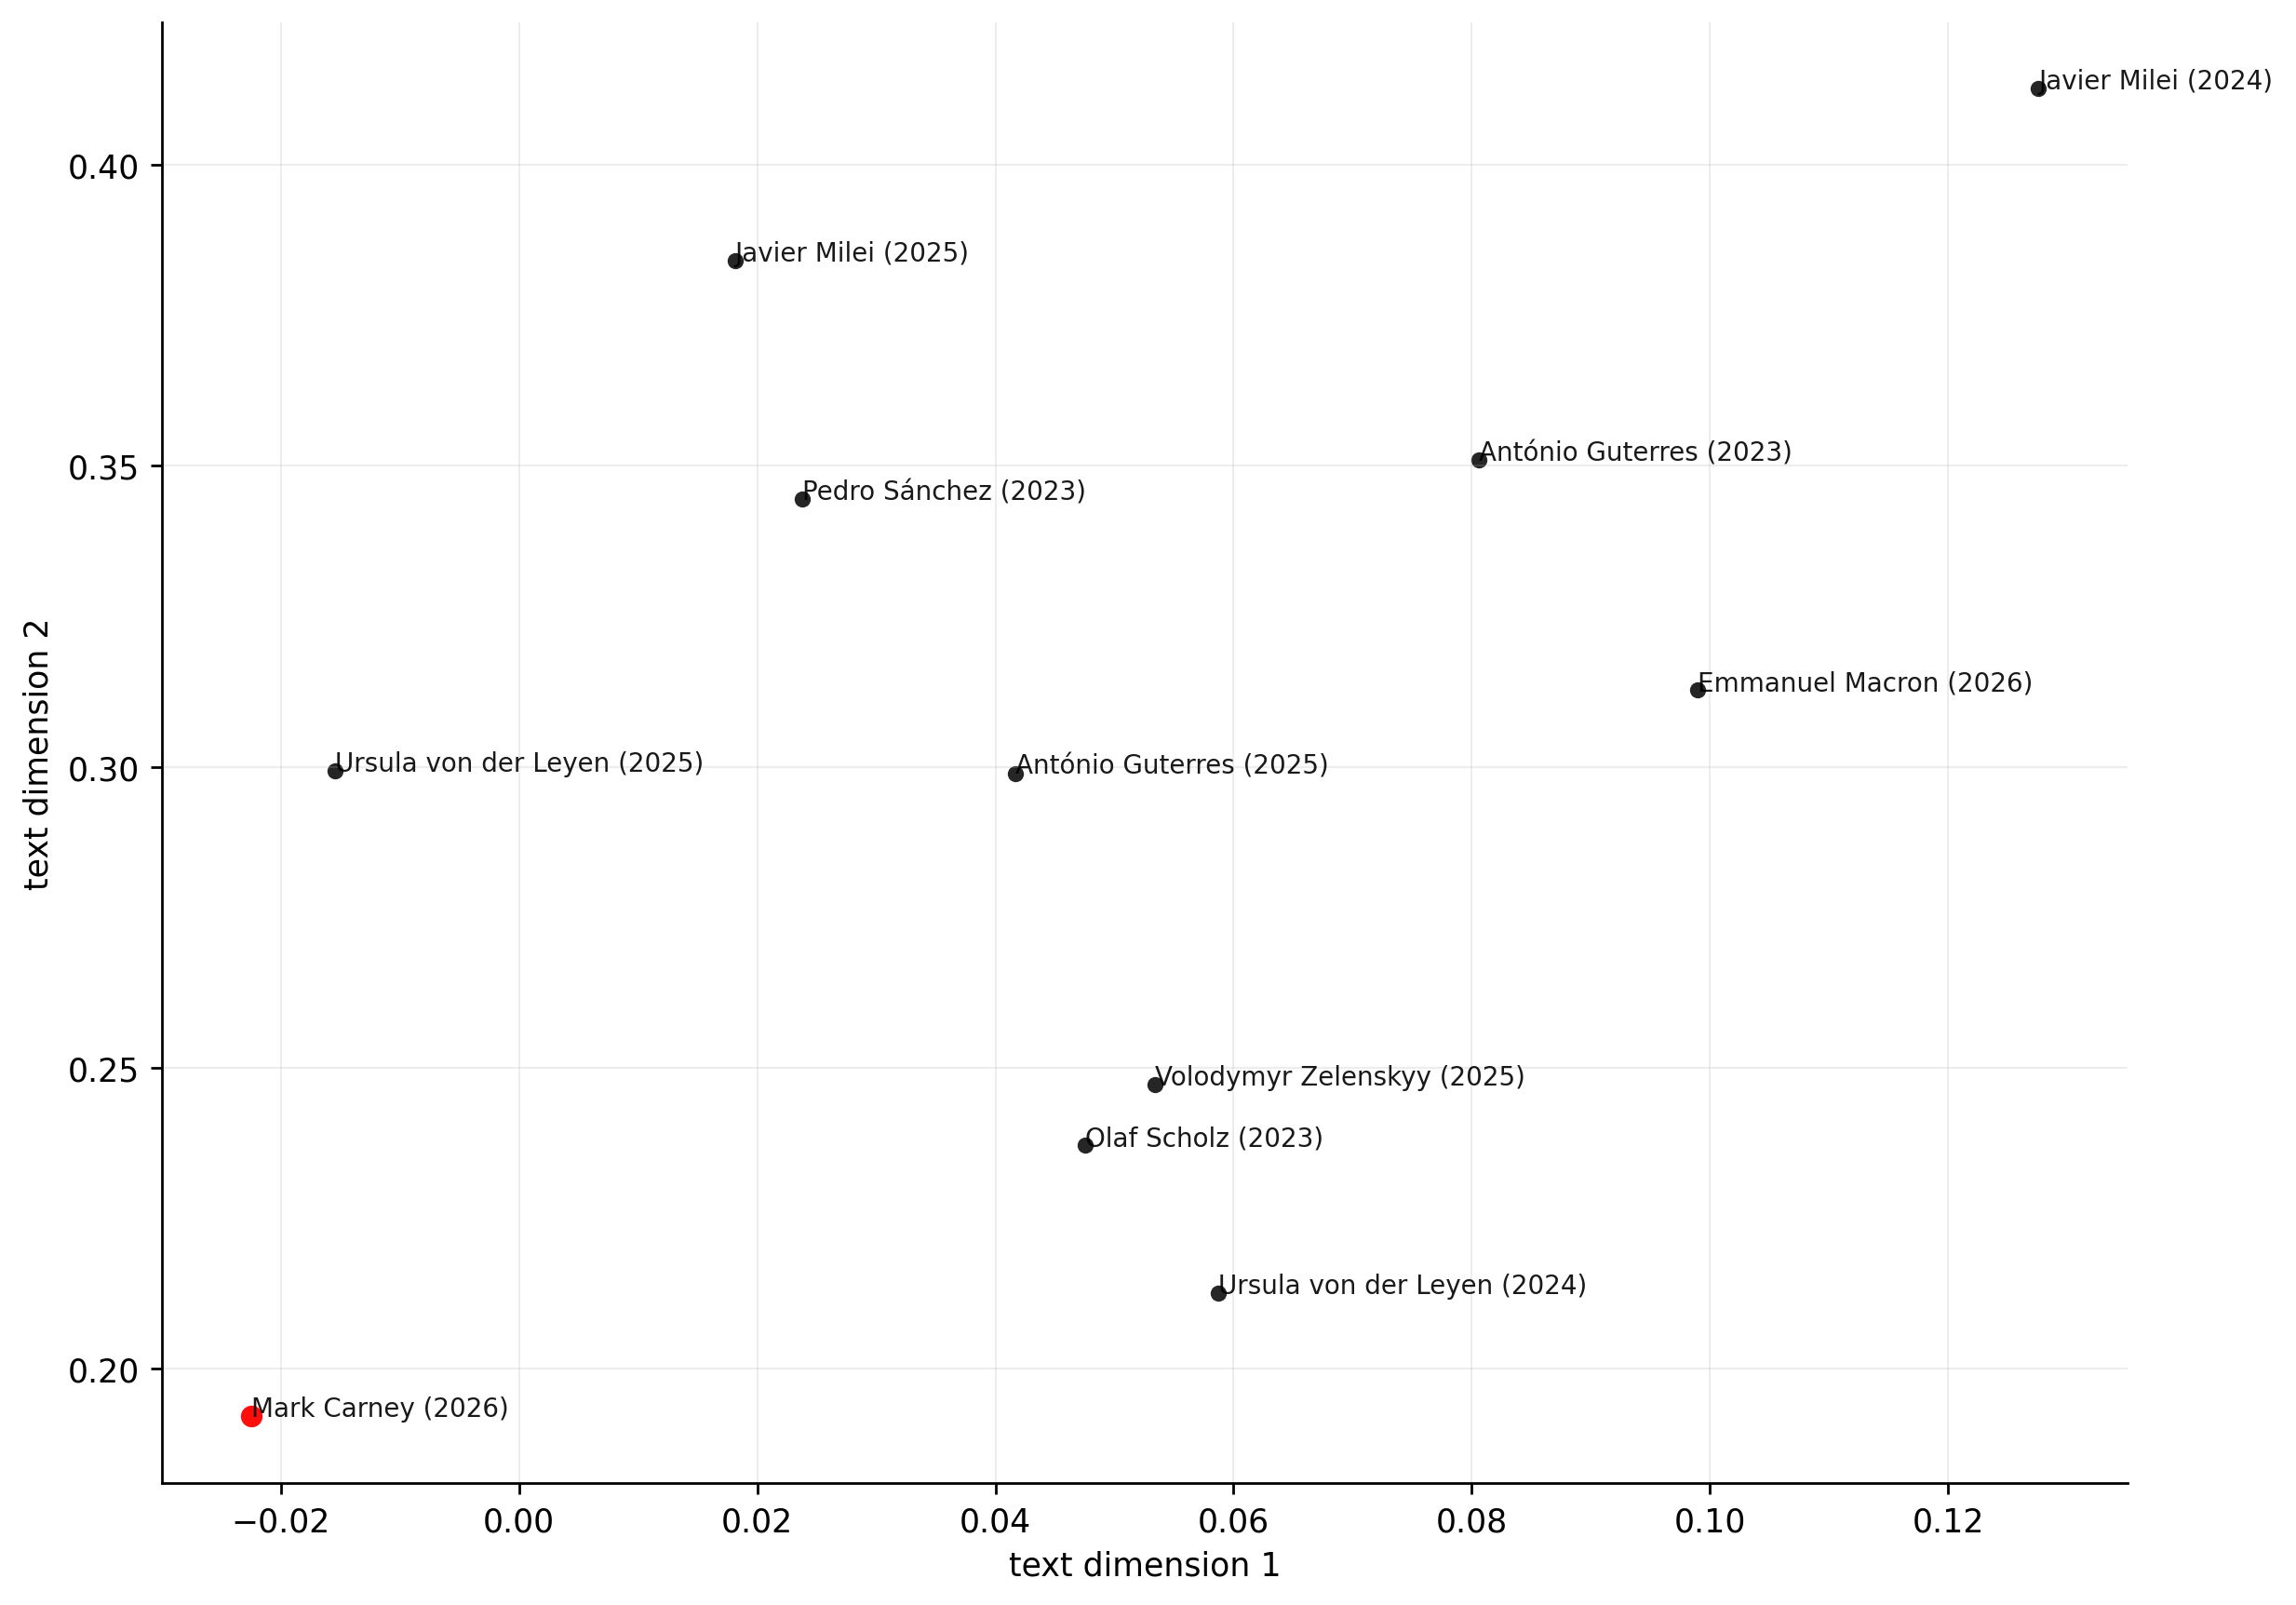

In [159]:
# Cell 3 — 2D SVD projection + professional scatter (black points; Marc Carney in red; higher resolution)
# Labels are "speaker (year)". Axes renamed as requested.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, random_state=0)
X_2d = svd.fit_transform(X_tfidf)


plot_df = corpus_data[["speaker", "year"]].copy()
plot_df["speaker"] = plot_df["speaker"].astype(str).str.strip()


plot_df["x"] = X_2d[:, 0]
plot_df["y"] = X_2d[:, 1]
plot_df["label"] = plot_df["speaker"].astype(str) + " (" + plot_df["year"].astype(str) + ")"

exclude_speakers = {"He Lifeng", "Ding Xuexiang", "Li Qiang"}

plot_df = plot_df[~plot_df["speaker"].isin(exclude_speakers)].reset_index(drop=True)


is_carney = plot_df["speaker"].astype(str).str.contains("Mark Carney", case=False, na=False)

fig, ax = plt.subplots(figsize=(10, 7), dpi=250)

# Plot non-Carney in black
ax.scatter(
    plot_df.loc[~is_carney, "x"],
    plot_df.loc[~is_carney, "y"],
    c="black",
    s=25,
    alpha=0.85,
    linewidths=0
)

# Plot Carney in red
ax.scatter(
    plot_df.loc[is_carney, "x"],
    plot_df.loc[is_carney, "y"],
    c="red",
    s=45,
    alpha=0.95,
    linewidths=0
)

# Annotate each point
for _, r in plot_df.iterrows():
    ax.annotate(r["label"], (r["x"], r["y"]), fontsize=8, alpha=0.9)

# Styling
ax.set_xlabel("text dimension 1")
ax.set_ylabel("text dimension 2")
ax.set_title("")  # remove title
ax.grid(True, linewidth=0.5, alpha=0.25)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()



In [160]:
# Cell 4 — Nearest neighbors to Mark Carney in 2D + terms driving similarity

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Rebuild a row-aligned df with row_id so we can map back to X_tfidf and X_2d correctly
df = corpus_data[["speaker", "year"]].copy()
df["speaker"] = df["speaker"].astype(str).str.strip()
df["row_id"] = np.arange(len(df))

exclude_speakers = {"He Lifeng", "Ding Xuexiang", "Li Qiang"}
df = df[~df["speaker"].isin(exclude_speakers)].copy()

# Attach the 2D coordinates from the already-computed X_2d
df["x"] = X_2d[df["row_id"].values, 0]
df["y"] = X_2d[df["row_id"].values, 1]
df["label"] = df["speaker"].astype(str) + " (" + df["year"].astype(str) + ")"

# Robust match for Mark/Marc Carney
carney_mask = df["speaker"].str.contains(r"\bMar[ck]\s+Carney\b", case=False, na=False)

carney_rows = df.loc[carney_mask, "row_id"].values
if len(carney_rows) == 0:
    print("No rows matched Mark/Marc Carney. Check spelling in corpus_data['speaker'].")
else:
    # If multiple Carney speeches exist, analyze each one separately
    k = 5  # number of nearest neighbors to display per Carney speech
    vocab = tfidf.get_feature_names_out()

    for i_row in carney_rows:
        carney_label = df.loc[df["row_id"] == i_row, "label"].iloc[0]
        carney_xy = X_2d[i_row, :]

        # Distances in 2D to all included points (excluding self)
        other = df[df["row_id"] != i_row].copy()
        other_xy = other[["x", "y"]].values
        dists = np.sqrt(((other_xy - carney_xy) ** 2).sum(axis=1))

        other = other.assign(dist_2d=dists).sort_values("dist_2d").head(k)

        print("\n" + "="*90)
        print(f"Carney point: {carney_label}")
        print("="*90)

        # Row vectors in TF-IDF space
        v_i = X_tfidf[i_row]

        for _, r in other.iterrows():
            j_row = int(r["row_id"])
            v_j = X_tfidf[j_row]

            # Cosine similarity in original TF-IDF space (more meaningful than 2D distance)
            cos = cosine_similarity(v_i, v_j)[0, 0]

            # Terms driving similarity: overlap contributions = tfidf_i * tfidf_j
            overlap = v_i.multiply(v_j)  # sparse, only shared non-zeros remain
            if overlap.nnz == 0:
                top_terms = []
            else:
                top_idx = np.argsort(overlap.data)[::-1][:10]
                top_terms = [(vocab[overlap.indices[t]], overlap.data[t]) for t in top_idx]

            print(f"\nNearest: {r['label']}")
            print(f"  2D distance: {r['dist_2d']:.4f} | cosine similarity (TF-IDF): {cos:.4f}")
            print("  Top shared terms driving similarity (tfidf_i * tfidf_j):")
            if not top_terms:
                print("    (no shared terms after preprocessing)")
            else:
                for term, w in top_terms:
                    print(f"    {term:25s} {w:.6f}")



Carney point: Mark Carney (2026)

Nearest: Olaf Scholz (2023)
  2D distance: 0.0832 | cosine similarity (TF-IDF): 0.0015
  Top shared terms driving similarity (tfidf_i * tfidf_j):
    friend time               0.000600
    thank much                0.000467
    free trade                0.000388

Nearest: Ursula von der Leyen (2024)
  2D distance: 0.0838 | cosine similarity (TF-IDF): 0.0026
  Top shared terms driving similarity (tfidf_i * tfidf_j):
    supply chain              0.000627
    problem solve             0.000428
    world want                0.000428
    come back                 0.000428
    thank much                0.000421
    would like                0.000246

Nearest: Volodymyr Zelenskyy (2025)
  2D distance: 0.0938 | cosine similarity (TF-IDF): 0.0014
  Top shared terms driving similarity (tfidf_i * tfidf_j):
    something else            0.000700
    new strategic             0.000350
    supply chain              0.000203
    long term                 0.000136



In [161]:
# Cell 5 — Interpret SVD dimensions + explain what drives Carney’s coordinates on each axis

import numpy as np

vocab = tfidf.get_feature_names_out()
comp1 = svd.components_[0]
comp2 = svd.components_[1]

def top_loadings(component, topn=15):
    # top positive and top negative loadings
    pos_idx = np.argsort(component)[::-1][:topn]
    neg_idx = np.argsort(component)[:topn]
    pos = [(vocab[i], component[i]) for i in pos_idx]
    neg = [(vocab[i], component[i]) for i in neg_idx]
    return pos, neg

pos1, neg1 = top_loadings(comp1, topn=12)
pos2, neg2 = top_loadings(comp2, topn=12)

print("\nTEXT DIMENSION 1 (SVD component 1) — top loading terms")
print("  Positive end:")
for t, w in pos1:
    print(f"    {t:25s} {w:+.6f}")
print("  Negative end:")
for t, w in neg1:
    print(f"    {t:25s} {w:+.6f}")

print("\nTEXT DIMENSION 2 (SVD component 2) — top loading terms")
print("  Positive end:")
for t, w in pos2:
    print(f"    {t:25s} {w:+.6f}")
print("  Negative end:")
for t, w in neg2:
    print(f"    {t:25s} {w:+.6f}")

# Explain Carney’s coordinates by term contributions: tfidf(term) * loading(term)
# (This shows what pushes Carney to the + or - direction on each axis.)

# Re-identify Carney row_ids (same robust regex)
df2 = corpus_data[["speaker", "year"]].copy()
df2["speaker"] = df2["speaker"].astype(str).str.strip()
df2["row_id"] = np.arange(len(df2))
exclude_speakers = {"He Lifeng", "Ding Xuexiang", "Li Qiang"}
df2 = df2[~df2["speaker"].isin(exclude_speakers)].copy()

carney_rows = df2.loc[df2["speaker"].str.contains(r"\bMar[ck]\s+Carney\b", case=False, na=False), "row_id"].values

if len(carney_rows) == 0:
    print("\nNo rows matched Mark/Marc Carney for contribution analysis.")
else:
    for i_row in carney_rows:
        label = df2.loc[df2["row_id"] == i_row, "speaker"].iloc[0] + " (" + str(df2.loc[df2["row_id"] == i_row, "year"].iloc[0]) + ")"
        x, y = X_2d[i_row, 0], X_2d[i_row, 1]
        print("\n" + "-"*90)
        print(f"Carney point: {label} | coordinates: (dim1={x:.4f}, dim2={y:.4f})")

        row = X_tfidf[i_row].toarray().ravel()

        contrib1 = row * comp1
        contrib2 = row * comp2

        # largest absolute contributions (both + and - are informative)
        topn = 12
        idx1 = np.argsort(np.abs(contrib1))[::-1][:topn]
        idx2 = np.argsort(np.abs(contrib2))[::-1][:topn]

        print("\n  Terms most responsible for Carney's position on text dimension 1:")
        for i in idx1:
            if row[i] > 0:
                print(f"    {vocab[i]:25s} contrib={contrib1[i]:+.6f} (tfidf={row[i]:.4f}, loading={comp1[i]:+.6f})")

        print("\n  Terms most responsible for Carney's position on text dimension 2:")
        for i in idx2:
            if row[i] > 0:
                print(f"    {vocab[i]:25s} contrib={contrib2[i]:+.6f} (tfidf={row[i]:.4f}, loading={comp2[i]:+.6f})")



TEXT DIMENSION 1 (SVD component 1) — top loading terms
  Positive end:
    China s                   +0.292633
    chinese economy           +0.141559
    high quality              +0.081521
    foreign investment        +0.066586
    green low carbon          +0.059155
    green low                 +0.059155
    reform opening            +0.057890
    major trend               +0.054276
    foreign invest            +0.054276
    share world opportunity   +0.052356
    share world               +0.052356
    world opportunity         +0.052356
  Negative end:
    across world              -0.003965
    great power               -0.003813
    middle power              -0.003745
    clean tech                -0.002644
    sign window               -0.002140
    critical mineral          -0.002140
    import Russia             -0.001983
    25 year                   -0.001983
    mutual benefit            -0.001607
    power rivalry             -0.001605
    like Canada               -0

# What if I had used count vectorizer?

In [162]:

# Use your preprocessed text column; fall back to full_text if needed
text_col = "text_preproc" if "text_preproc" in corpus_data.columns else "full_text"

cv = CountVectorizer(
    ngram_range=(2,3),
    min_df=1,
    max_df=0.75,
    lowercase=False,              # IMPORTANT: preserves acronyms like IMF, UN, EU
    token_pattern=r"(?u)\b\w+\b"  # keep short tokens too (e.g., "UN")
)

X_cv = cv.fit_transform(corpus_data[text_col].fillna("").astype(str))
terms = cv.get_feature_names_out()
print("Count vectorizer matrix shape:", X_cv.shape)
print("Vocabulary size:", len(terms))

Count vectorizer matrix shape: (14, 26833)
Vocabulary size: 26833


In [ ]:
mask_carney = corpus_data["speaker"].astype(str).str.contains("Mark Carney", case=False, na=False)
idx_carney = np.where(mask_carney.values)[0]

if len(idx_carney) == 0:
    print("No rows found for speaker containing 'Marc Carney'. Check corpus_data['speaker'].unique().")
else:
    carney_mean = X_cv[idx_carney].mean(axis=0)   # 1 x V sparse/dense matrix
    carney_mean = np.asarray(carney_mean).ravel()

    top_idx = np.argsort(carney_mean)[::-1][:10]
    top_terms = [(terms[i], carney_mean[i]) for i in top_idx]

    print(f"Top 10 terms for Mark Carney (n_docs={len(idx_carney)}):")
    for t, w in top_terms:
        print(f"{t:25s} {w:.4f}")


Top 10 terms for Mark Carney (n_docs=1):
great power               7.0000
middle power              7.0000
rule base                 4.0000
critical mineral          4.0000
sign window               4.0000
act together              3.0000
place sign                3.0000
like Canada               3.0000
great power rivalry       3.0000
power rivalry             3.0000


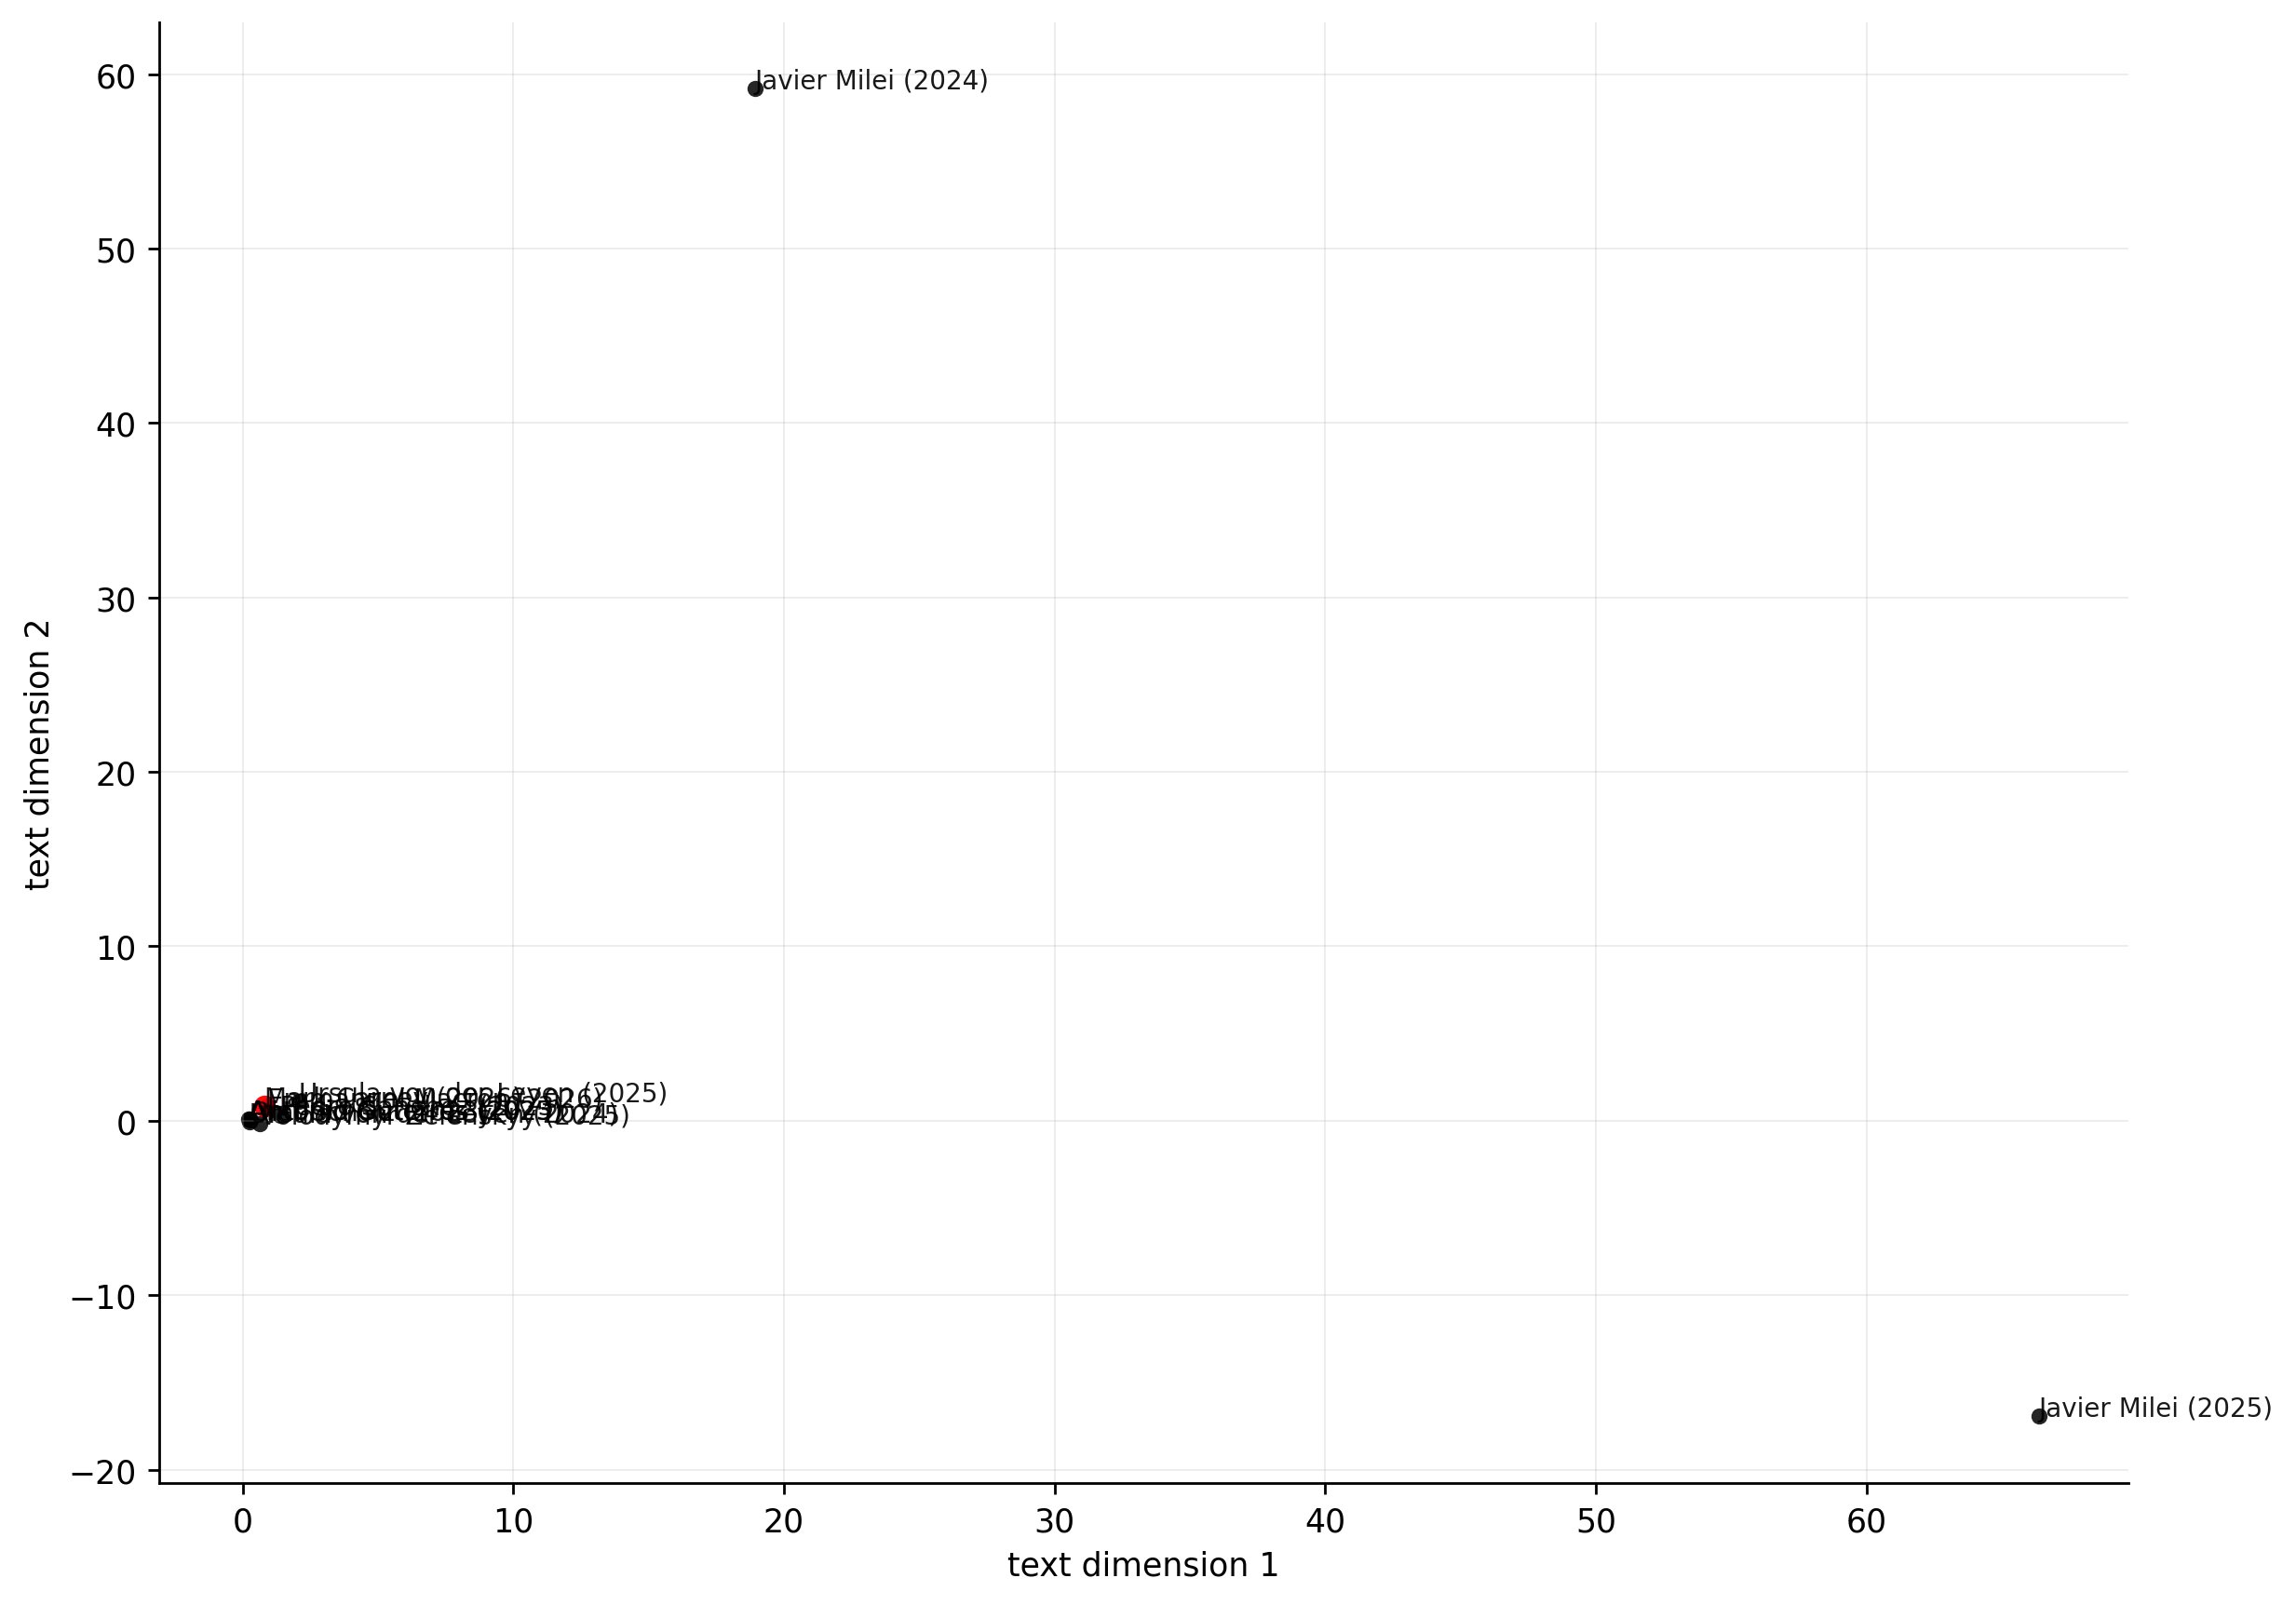

In [ ]:
#plotting in 2d again for countvectorizer

svd = TruncatedSVD(n_components=2, random_state=0)
X_2d = svd.fit_transform(X_cv)


plot_df = corpus_data[["speaker", "year"]].copy()
plot_df["speaker"] = plot_df["speaker"].astype(str).str.strip()


plot_df["x"] = X_2d[:, 0]
plot_df["y"] = X_2d[:, 1]
plot_df["label"] = plot_df["speaker"].astype(str) + " (" + plot_df["year"].astype(str) + ")"

exclude_speakers = {"He Lifeng", "Ding Xuexiang", "Li Qiang"}

plot_df = plot_df[~plot_df["speaker"].isin(exclude_speakers)].reset_index(drop=True)


is_carney = plot_df["speaker"].astype(str).str.contains("Mark Carney", case=False, na=False)

fig, ax = plt.subplots(figsize=(10, 7), dpi=250)

# Plot non-Carney in black
ax.scatter(
    plot_df.loc[~is_carney, "x"],
    plot_df.loc[~is_carney, "y"],
    c="black",
    s=25,
    alpha=0.85,
    linewidths=0
)

# Plot Carney in red
ax.scatter(
    plot_df.loc[is_carney, "x"],
    plot_df.loc[is_carney, "y"],
    c="red",
    s=45,
    alpha=0.95,
    linewidths=0
)

# Annotate each point
for _, r in plot_df.iterrows():
    ax.annotate(r["label"], (r["x"], r["y"]), fontsize=8, alpha=0.9)

# Styling
ax.set_xlabel("text dimension 1")
ax.set_ylabel("text dimension 2")
ax.set_title("")  # remove title
ax.grid(True, linewidth=0.5, alpha=0.25)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


# Not good. What is going on? 

The tf-idf vectorizer has a normalization step that is used in default. We need to implement the l2 norm that is the default in the tf-dif vectorizer.

The line below is X_cv_l2 = normalize(X_cv, norm="l2", axis=1, copy=True)  # stays sparse

But what does this do under the hood?

row_sumsq = np.asarray(X_cv.multiply(X_cv).sum(axis=1)).ravel()  # sum of squares per row

norms = np.sqrt(row_sumsq)

inv_norms = np.zeros_like(norms)

mask = norms != 0

inv_norms[mask] = 1.0 / norms[mask]

X_cv_l2 = X_cv.multiply(inv_norms[:, None])

In [172]:
from sklearn.preprocessing import normalize

# Use your preprocessed text column; fall back to full_text if needed
text_col = "text_preproc" if "text_preproc" in corpus_data.columns else "full_text"

cv = CountVectorizer(
    ngram_range=(2,3),
    min_df=1,
    max_df=0.75,
    lowercase=False,              # IMPORTANT: preserves acronyms like IMF, UN, EU
    token_pattern=r"(?u)\b\w+\b"  # keep short tokens too (e.g., "UN")
)

X_cv = cv.fit_transform(corpus_data[text_col].fillna("").astype(str))
terms = cv.get_feature_names_out()
print("Count vectorizer matrix shape:", X_cv.shape)
print("Vocabulary size:", len(terms))

#adding normalization step
#version 1
X_cv_l2 = normalize(X_cv, norm="l2", axis=1, copy=True)


Count vectorizer matrix shape: (14, 26833)
Vocabulary size: 26833


In [173]:
X_dense = X_cv.toarray()  # WARNING: can be huge

norms = np.linalg.norm(X_dense, ord=2, axis=1, keepdims=True)  # shape (n_docs, 1)
norms[norms == 0] = 1.0  # avoid divide-by-zero for empty docs

X_dense_l2 = X_dense / norms

In [174]:

mask_carney = corpus_data["speaker"].astype(str).str.contains("Mark Carney", case=False, na=False)
idx_carney = np.where(mask_carney.values)[0]

if len(idx_carney) == 0:
    print("No rows found for speaker containing 'Marc Carney'. Check corpus_data['speaker'].unique().")
else:
    carney_mean = X_dense_l2[idx_carney].mean(axis=0)   # 1 x V sparse/dense matrix
    carney_mean = np.asarray(carney_mean).ravel()

    top_idx = np.argsort(carney_mean)[::-1][:10]
    top_terms = [(terms[i], carney_mean[i]) for i in top_idx]

    print(f"Top 10 terms for Mark Carney (n_docs={len(idx_carney)}):")
    for t, w in top_terms:
        print(f"{t:25s} {w:.4f}")

Top 10 terms for Mark Carney (n_docs=1):
great power               0.1394
middle power              0.1394
rule base                 0.0797
critical mineral          0.0797
sign window               0.0797
act together              0.0598
place sign                0.0598
like Canada               0.0598
great power rivalry       0.0598
power rivalry             0.0598


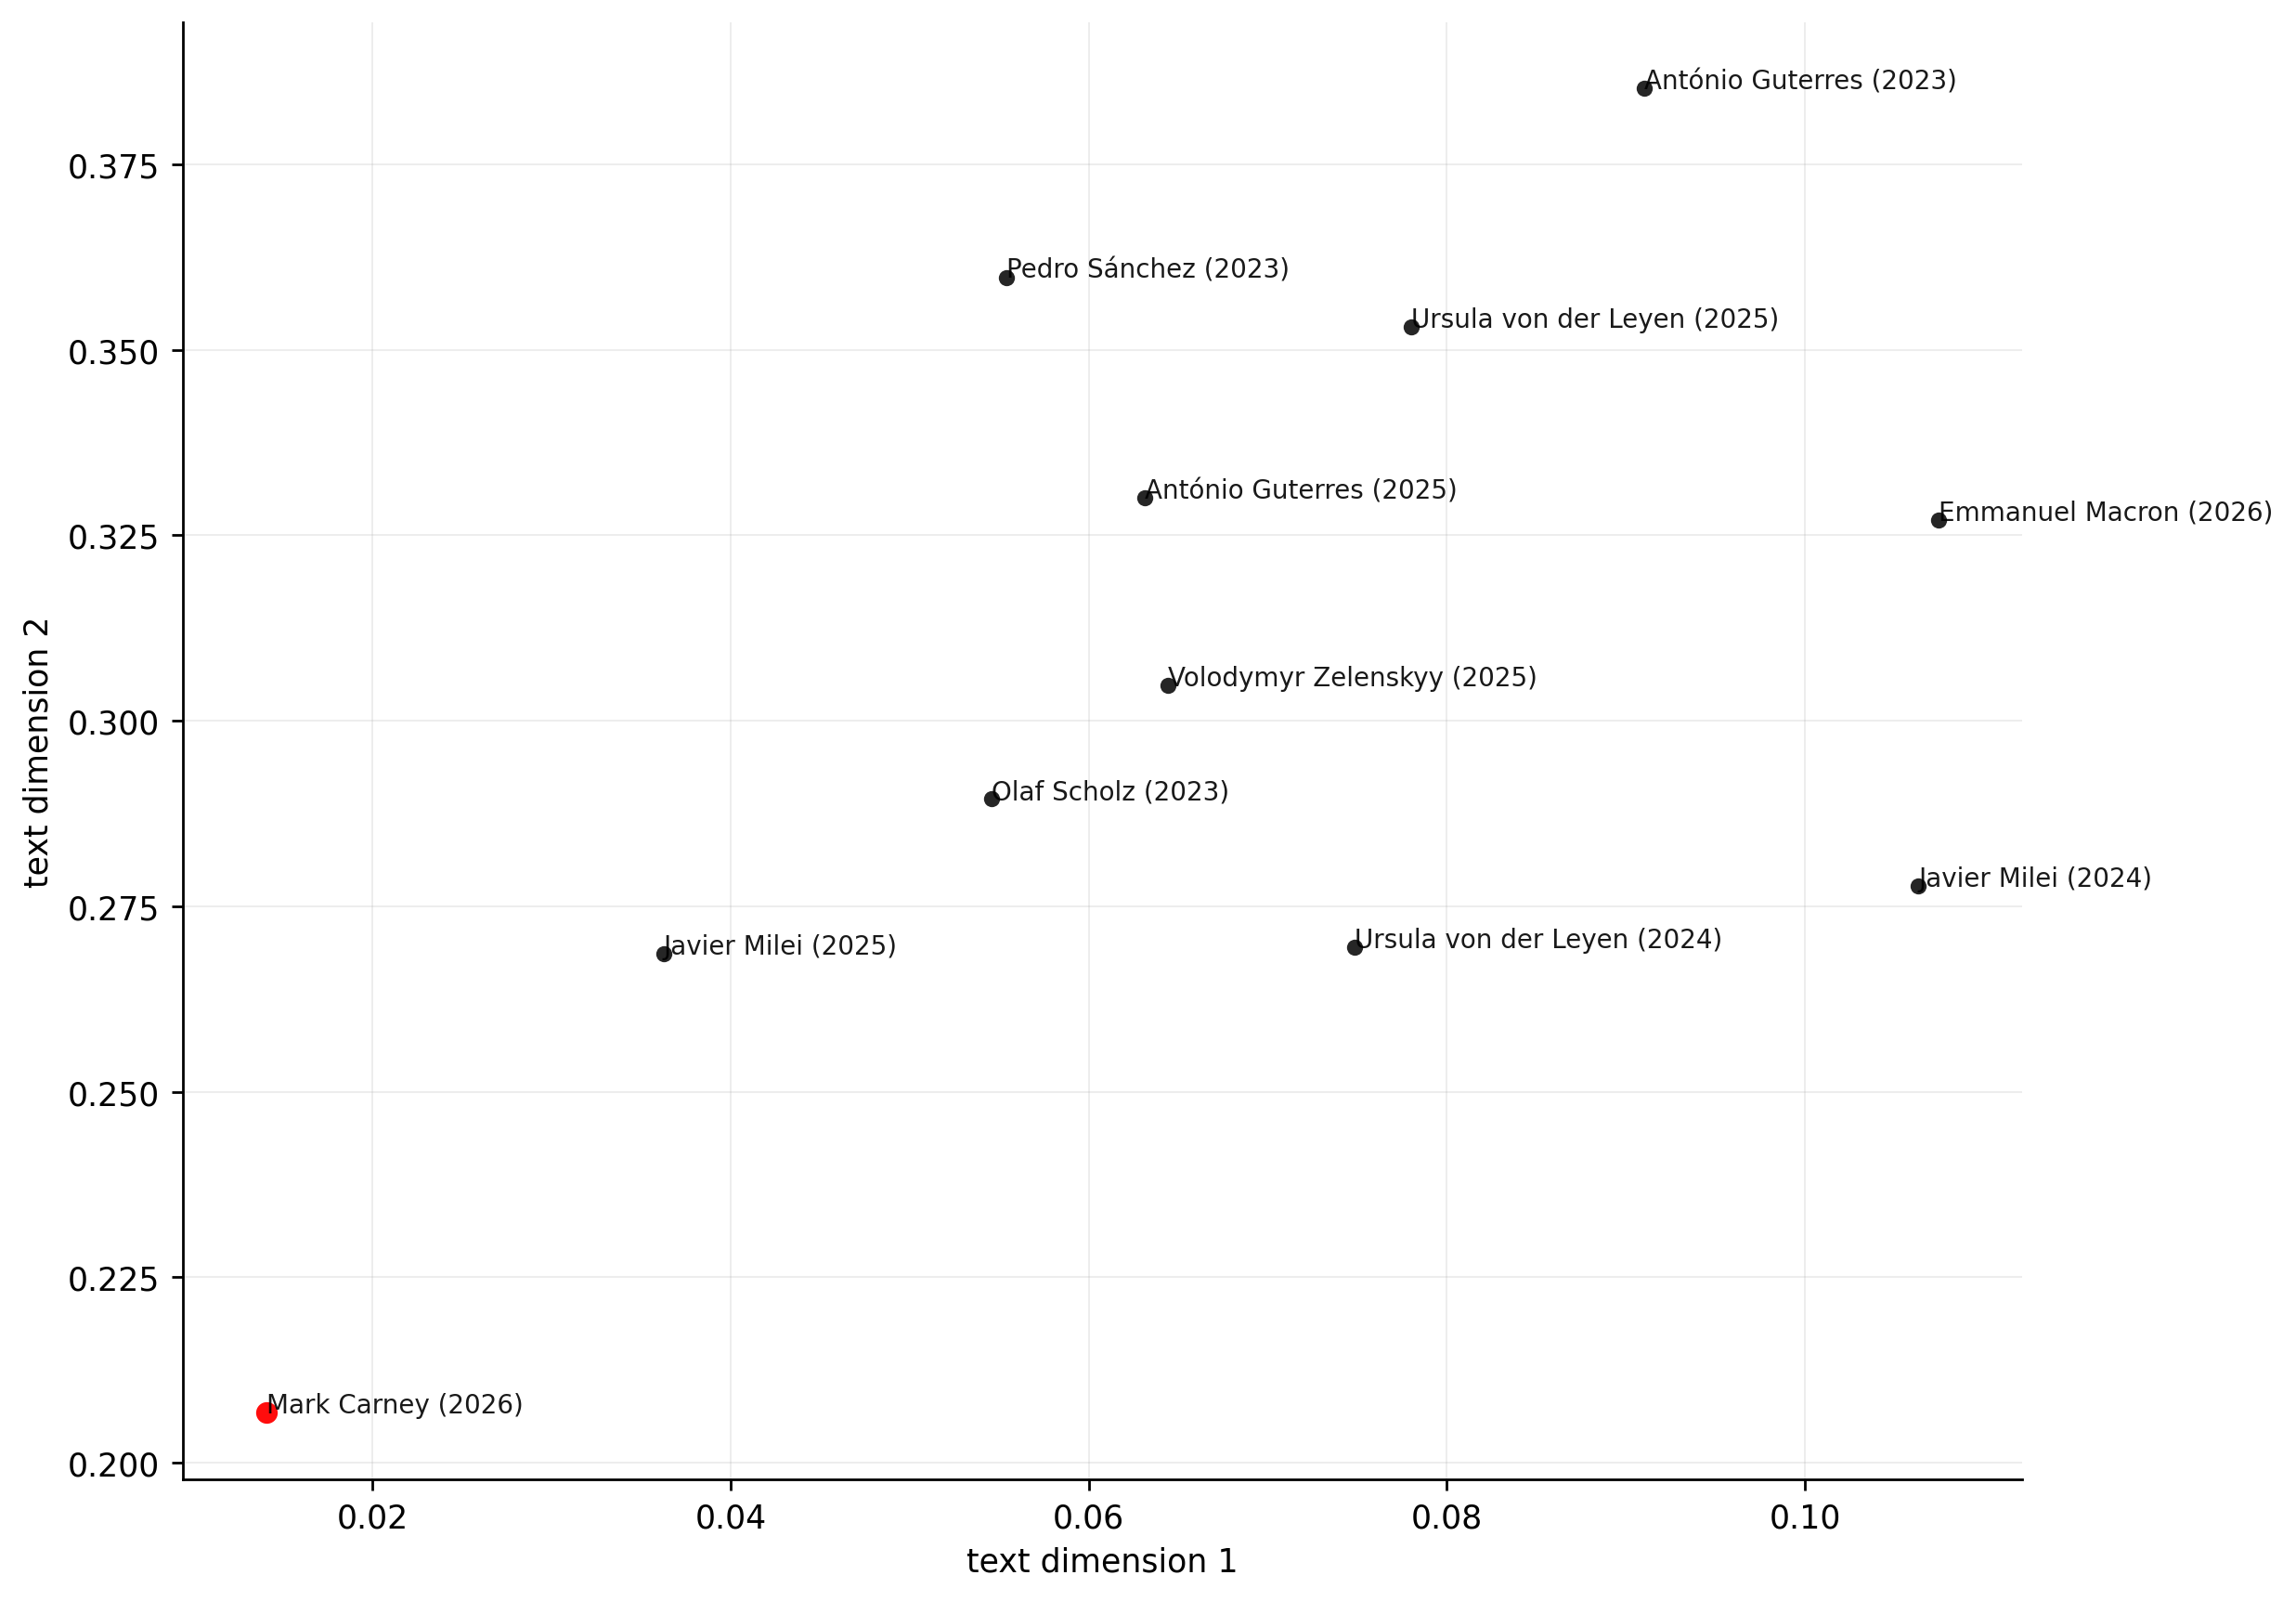

In [175]:

svd = TruncatedSVD(n_components=2, random_state=0)
X_2d = svd.fit_transform(X_dense_l2)


plot_df = corpus_data[["speaker", "year"]].copy()
plot_df["speaker"] = plot_df["speaker"].astype(str).str.strip()


plot_df["x"] = X_2d[:, 0]
plot_df["y"] = X_2d[:, 1]
plot_df["label"] = plot_df["speaker"].astype(str) + " (" + plot_df["year"].astype(str) + ")"

exclude_speakers = {"He Lifeng", "Ding Xuexiang", "Li Qiang"}

plot_df = plot_df[~plot_df["speaker"].isin(exclude_speakers)].reset_index(drop=True)


is_carney = plot_df["speaker"].astype(str).str.contains("Mark Carney", case=False, na=False)

fig, ax = plt.subplots(figsize=(10, 7), dpi=250)

# Plot non-Carney in black
ax.scatter(
    plot_df.loc[~is_carney, "x"],
    plot_df.loc[~is_carney, "y"],
    c="black",
    s=25,
    alpha=0.85,
    linewidths=0
)

# Plot Carney in red
ax.scatter(
    plot_df.loc[is_carney, "x"],
    plot_df.loc[is_carney, "y"],
    c="red",
    s=45,
    alpha=0.95,
    linewidths=0
)

# Annotate each point
for _, r in plot_df.iterrows():
    ax.annotate(r["label"], (r["x"], r["y"]), fontsize=8, alpha=0.9)

# Styling
ax.set_xlabel("text dimension 1")
ax.set_ylabel("text dimension 2")
ax.set_title("")  # remove title
ax.grid(True, linewidth=0.5, alpha=0.25)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


# Why is the result so similar?

Tf-idf is very useful to change the ranking of terms within the document - it captures what makes a document different. This also typically has some impact on how "different" a documents appears from other documents. This was my intuition in designing the notebook.

However, here two very special things are happening. First, the terms that make his speech special only appear in his speech (df=1) AND they appear a lot in his speech. This means the count vectorizer is able to pick up the same special terms as the tf-idf vectorizer. In addition, normalization makes some of the reweighting less salient as we are not exploding the importance of the terms that only appear in his speech as much.

